In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = "YOUR API KEY GOES HERE"

In [2]:
!pip install -qU langchain-mistralai

In [3]:
import getpass
import os

if not os.environ.get("MISTRAL_API_KEY"):
  os.environ["MISTRAL_API_KEY"] = "your-api-key"

from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(model="mistral-large-latest")

/Users/adityabagri/Desktop/RAG/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
!pip install -qU langchain-huggingface

In [8]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [9]:
!pip install -qU langchain-core

In [10]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [11]:
from langchain_community.document_loaders import PyPDFLoader

In [12]:
!pip install pypdf

  Using cached pypdf-5.1.0-py3-none-any.whl.metadata (7.2 kB)
Using cached pypdf-5.1.0-py3-none-any.whl (297 kB)


In [14]:
# # Loading a PDF Directory
# from langchain_community.document_loaders import PyPDFDirectoryLoader

# loader = PyPDFDirectoryLoader("/content/drive/MyDrive/Regulations")
# docs = loader.load()

from langchain_community.document_loaders import PyPDFLoader
import os

def load_pdfs_as_documents(directory):
    documents = []
    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            print("Loading PDF:", filename)
            filepath = os.path.join(directory, filename)
            loader = PyPDFLoader(filepath)
            docs = loader.load()
            full_text = "\n".join([page.page_content for page in docs])
            print(f"Total characters: {len(full_text)}")
            from langchain.schema import Document

            single_doc = Document(page_content=full_text)
            documents.append(single_doc)
    return documents

# Usage
pdf_docs = load_pdfs_as_documents("Data")

Loading PDF: 2024-May-UG Regulations.pdf
Total characters: 46031


In [15]:
len(pdf_docs)

1

In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=400,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(pdf_docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 75 sub-documents.


In [17]:
from tqdm import tqdm

for doc in tqdm(all_splits, desc="Adding documents to vector store"):
    vector_store.add_documents([doc])

Adding documents to vector store: 100%|██████████| 75/75 [00:10<00:00,  7.28it/s]


In [18]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [24]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [25]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

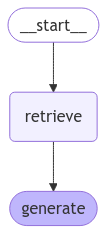

In [26]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
result = graph.invoke({"question": "What are the minimum credits a student can take in one semester?"})
print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='3532f892-970e-4c71-b511-c439257c5913', metadata={'start_index': 7329}, page_content='credits assigned for that course. \n \na) A 4-credit course. The course will have 3 hours of lectures per week, with a total \nof about 39 hours of lectures (13 weeks). In addition, one hour of interaction per \nweek is expected, which may be in form of structured tutorials. There may also be \nlabs in the course. \n \n 5 \n \nb) A 2 -credit course . The course will have 1.5 h ours of lectures per week for the \nwhole semester, or 3 h ours of lectures per week for half the semester. The total \nlectures hours will be about 20. Intensive short -term courses of 2 credits are also \npossible, though it is expected that the duration of such a course will be no less than \n3 weeks. A 2-credit course may or may not have tutorials and labs. \n \nc) A 1 -credit course . The course is likely to be run as a short course on a very \nspecialized topic. Such courses may also be run during vac